In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image

from tqdm.notebook import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

An important detail to note is that neural networks from the torch library are trained with tensor values ranging from 0 to 1.

In [3]:
imsize = 512 if torch.cuda.is_available() else 128

# without the use of "convert("RGB") the image was being converted to a tensor with 4 channels 'RGBA' a for alpha layer"
loader = transforms.Compose([transforms.Lambda(lambda img : img.convert("RGB")),transforms.Resize(imsize),transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

def image_loader(image_path):
    image = Image.open(image_path)
    image = loader(image).unsqueeze(0)
    return image.to(device,torch.float)

style_image = image_loader("./images/style/style_image_1.png")
content_image = image_loader("./images/content/content_image_1.png")

print(style_image.size())

assert style_image.size() == content_image.size(),"content and style img need to of the the same size"

torch.Size([1, 3, 512, 512])


In [4]:
unloader = transforms.ToPILImage()

plt.ion() #this turns on interactive mode

def img_show(tensor,title=None):
    image = tensor.cpu().clone()
    denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.squeeze(0)
    image = denormalization(image).clamp(0, 1)
    image = unloader(image)
    plt.imshow(image)
    if title is not None :
        plt.title(title)

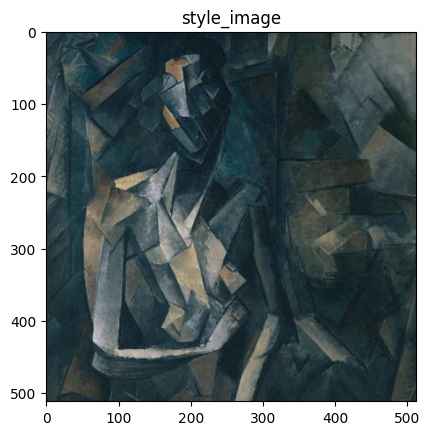

In [5]:
img_show(style_image,title='style_image')

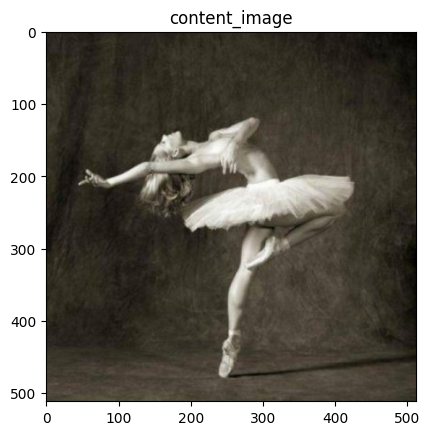

In [6]:
img_show(content_image,title='content_image')

In [7]:
def get_content_loss(content,target):
    return torch.mean((content-target)**2)/2

def gram_matrix(input):
    _,c,h,w = input.size()
    input = input.view(c,h*w)
    G = torch.mm(input,input.t())
    return G

def get_style_loss(style,target):
    _,c,h,w = target.size()
    Gt = gram_matrix(target)
    Gs = gram_matrix(style)
    return torch.mean((Gt-Gs)**2)/((c*h*w))

In [8]:
class VGG(nn.Module):
    def __init__(self):
        super().__init__()
        self.select_features = ['0','5','10','19','28'] # selecting the conv layers
        self.vgg = models.vgg19(pretrained=True).features #loading a pretrained vgg19 and accessing it's features layer i.e conv(feature extraction) layer excluding classifer(fully connected layer)
    
    def forward(self,output):
        features = []
        for name , layer in self.vgg._modules.items():
            output = layer(output)
            if name in self.select_features:
                features.append(output)
        return features

vgg = VGG().to(device).eval()

/home/sapien/dev/ml/tgpu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sapien/dev/ml/tgpu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
def save(target, i):
  denormalization = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
  img = target.clone().squeeze()
  img = denormalization(img).clamp(0, 1)
  save_image(img, f'./result/result_{i}.png')

def adam_optimer(x,y):
    return optim.Adam([x],lr=y)

def lbfgs_optimizer(x):
   return optim.LBFGS([x])

In [ ]:
model = models.vgg19(pretrained = True).features

target_image = content_image.clone().requires_grad_(True)

t_loss, s_loss, c_loss = [], [], []
#optimizer = adam_optimer(target_image,0.001)
optimizer = lbfgs_optimizer(target_image)

steps = 300
beta = 1000000 
alpha = 1

for step in tqdm(range(steps)):
    def closure():
        
        optimizer.zero_grad()

        # below this till backward() will work for adam outside of the function no need of closure in adam
        #obtaining the feature vector representation for every image
        target_feature = vgg(target_image)
        style_feature = vgg(style_image)
        content_feature = vgg(content_image)
        
        style_loss = 0
        content_loss = 0

        for target,content,style in zip(target_feature,content_feature,style_feature):
            content_loss += get_content_loss(content,target)
            style_loss += get_style_loss(style,target)

        total_loss = alpha*content_loss + beta*style_loss
        #compute the gradient
        total_loss.backward()

        return total_loss

    #updating the parameters
    loss = optimizer.step(closure)
    
    if step % 15 == 0:
        with torch.no_grad():
            target_feature = vgg(target_image)
            style_feature = vgg(style_image)
            content_feature = vgg(content_image)

        style_loss = 0
        content_loss = 0

        for target, content, style in zip(target_feature, content_feature, style_feature):
            content_loss += get_content_loss(content, target)
            style_loss += get_style_loss(style, target)

        total_loss = alpha * content_loss + beta * style_loss
        print(f'step: {step}, content loss: {content_loss.item():.4f}, style loss: {style_loss.item():.4f}')
        c_loss.append(content_loss.item())
        s_loss.append(style_loss.item())
        t_loss.append(total_loss.item())

    if step % 30 == 0:
        save(target_image, step)

/home/sapien/dev/ml/tgpu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sapien/dev/ml/tgpu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/300 [00:00<?, ?it/s]

step: 0, content loss: 3.9487, style loss: 8.5821
step: 15, content loss: 4.9874, style loss: 0.0333
step: 30, content loss: 5.1179, style loss: 0.0177
step: 45, content loss: 5.1601, style loss: 0.0150
step: 60, content loss: 5.1856, style loss: 0.0139
step: 75, content loss: 5.2017, style loss: 0.0132
step: 90, content loss: 5.2135, style loss: 0.0128
step: 105, content loss: 5.2228, style loss: 0.0125
step: 120, content loss: 5.2308, style loss: 0.0123
step: 135, content loss: 5.2371, style loss: 0.0121
step: 150, content loss: 5.2422, style loss: 0.0120
step: 165, content loss: 5.2466, style loss: 0.0119
step: 180, content loss: 5.2500, style loss: 0.0118
step: 195, content loss: 5.2529, style loss: 0.0117
step: 210, content loss: 5.2552, style loss: 0.0116
step: 225, content loss: 5.2571, style loss: 0.0116
step: 240, content loss: 5.2586, style loss: 0.0115
step: 255, content loss: 5.2603, style loss: 0.0115
step: 270, content loss: 5.2617, style loss: 0.0115
step: 285, content l

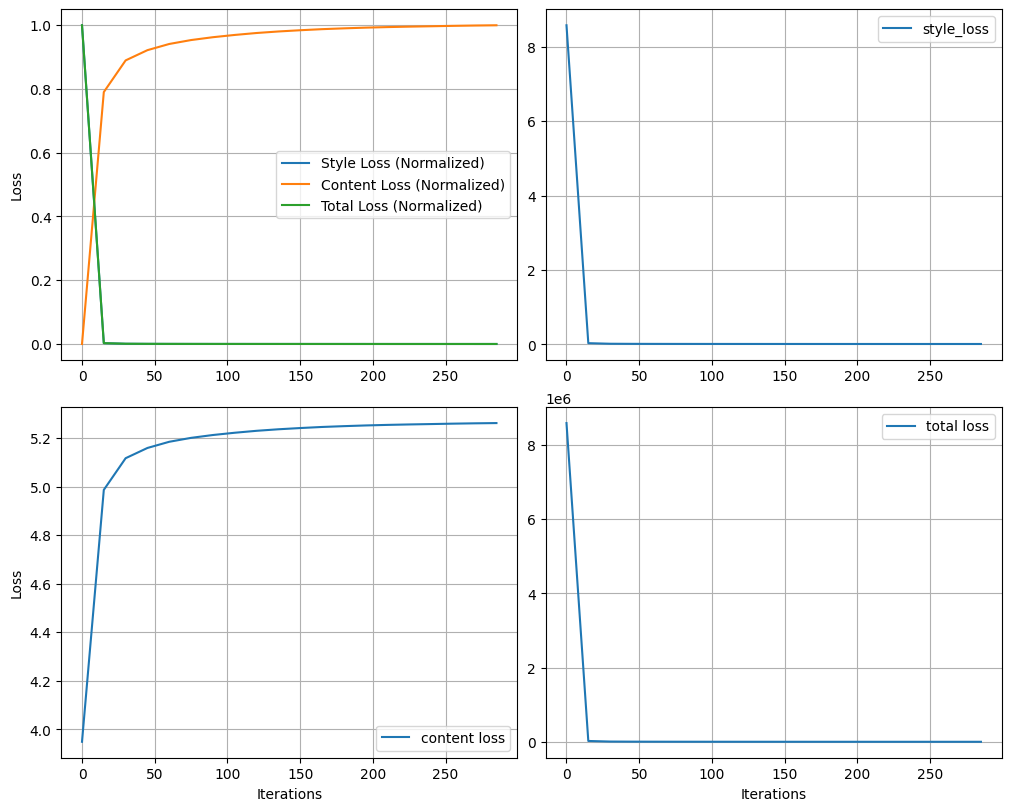

In [99]:
def normalize(l):
    return [(x - min(l)) / (max(l) - min(l)) for x in l]

s = [i for i in range(0,300,15)]

fig , axs = plt.subplots(2,2,layout='constrained',figsize=(10,8))
cbl = axs[0][0]
cbl.plot(s, normalize(s_loss), label='Style Loss (Normalized)')
cbl.plot(s, normalize(c_loss), label='Content Loss (Normalized)')
cbl.plot(s, normalize(t_loss), label='Total Loss (Normalized)')
cbl.grid(True)
cbl.legend()

sl = axs[0][1]
sl.plot(s,s_loss,label='style_loss')
sl.grid(True)
sl.legend()

cl = axs[1][0]
cl.plot(s,c_loss,label='content loss')
cl.grid(True)
cl.legend()

tl = axs[1][1]
tl.plot(s,t_loss,label='total loss')
tl.grid(True)
tl.legend()

tl.set_xlabel("Iterations")
cbl.set_ylabel("Loss")
cl.set_xlabel("Iterations")
cl.set_ylabel("Loss")

plt.show()